# Practical Lab 2: Multivariate Linear Regression, Non-Parametric Models and Cross-Validation

## CSCN8010-25S-Sec1-Foundations of Machine Learning

**Objective: Build a model that can best predict the risk of diabetes progression.**
This will be used as a screening tool to help physicians with identifying patients at risk.

## Models to be explored:
1. Univariate polynomial regression models 
1. Multivariate Polynomial models 
1. Decision Trees 
1. kNNs 

Evaluation Metrics: R-squared, Mean Absolute Percentage Error (MAPE), and Mean Absolute Error (MAE).

Evaluation will use a train-validation-test split.


# Data Preparation and Exploration

**1: Get the Data**

The dataset: Scikit-Learn Diabetes dataset.


In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Load the diabetes dataset. Using as_frame=True to get a Pandas DataFrame.

In [2]:
diabetes_df_bunch = datasets.load_diabetes(as_frame=True)
X = diabetes_df_bunch.data
y = diabetes_df_bunch.target

First 5 rows of features:

In [3]:
print(X.head())

        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641  


First 5 rows of target:

In [4]:
print(y.head())

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64


### 2. Problem Framed
* Dependent variable (target): 'disease progression one year after baseline'
* Independent variables (features): All other attributes in the dataset
* Goal: Predict 'disease progression one year after baseline' using the given features.

### 3. Exploratory Data Analysis (EDA)

In [5]:
full_df = pd.concat([X, y.rename("target")], axis=1)

### Statistics

Dataset Description (Statistics):


In [6]:
print(full_df.describe())

                age           sex           bmi            bp            s1  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   
min   -1.072256e-01 -4.464164e-02 -9.027530e-02 -1.123988e-01 -1.267807e-01   
25%   -3.729927e-02 -4.464164e-02 -3.422907e-02 -3.665608e-02 -3.424784e-02   
50%    5.383060e-03 -4.464164e-02 -7.283766e-03 -5.670422e-03 -4.320866e-03   
75%    3.807591e-02  5.068012e-02  3.124802e-02  3.564379e-02  2.835801e-02   
max    1.107267e-01  5.068012e-02  1.705552e-01  1.320436e-01  1.539137e-01   

                 s2            s3            s4            s5            s6  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean   3.918434e-17 -5.777179e-18 -9.042540e-18  9.293722e-17  1.130318e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.

### Histograms

Histograms of Features and Target:

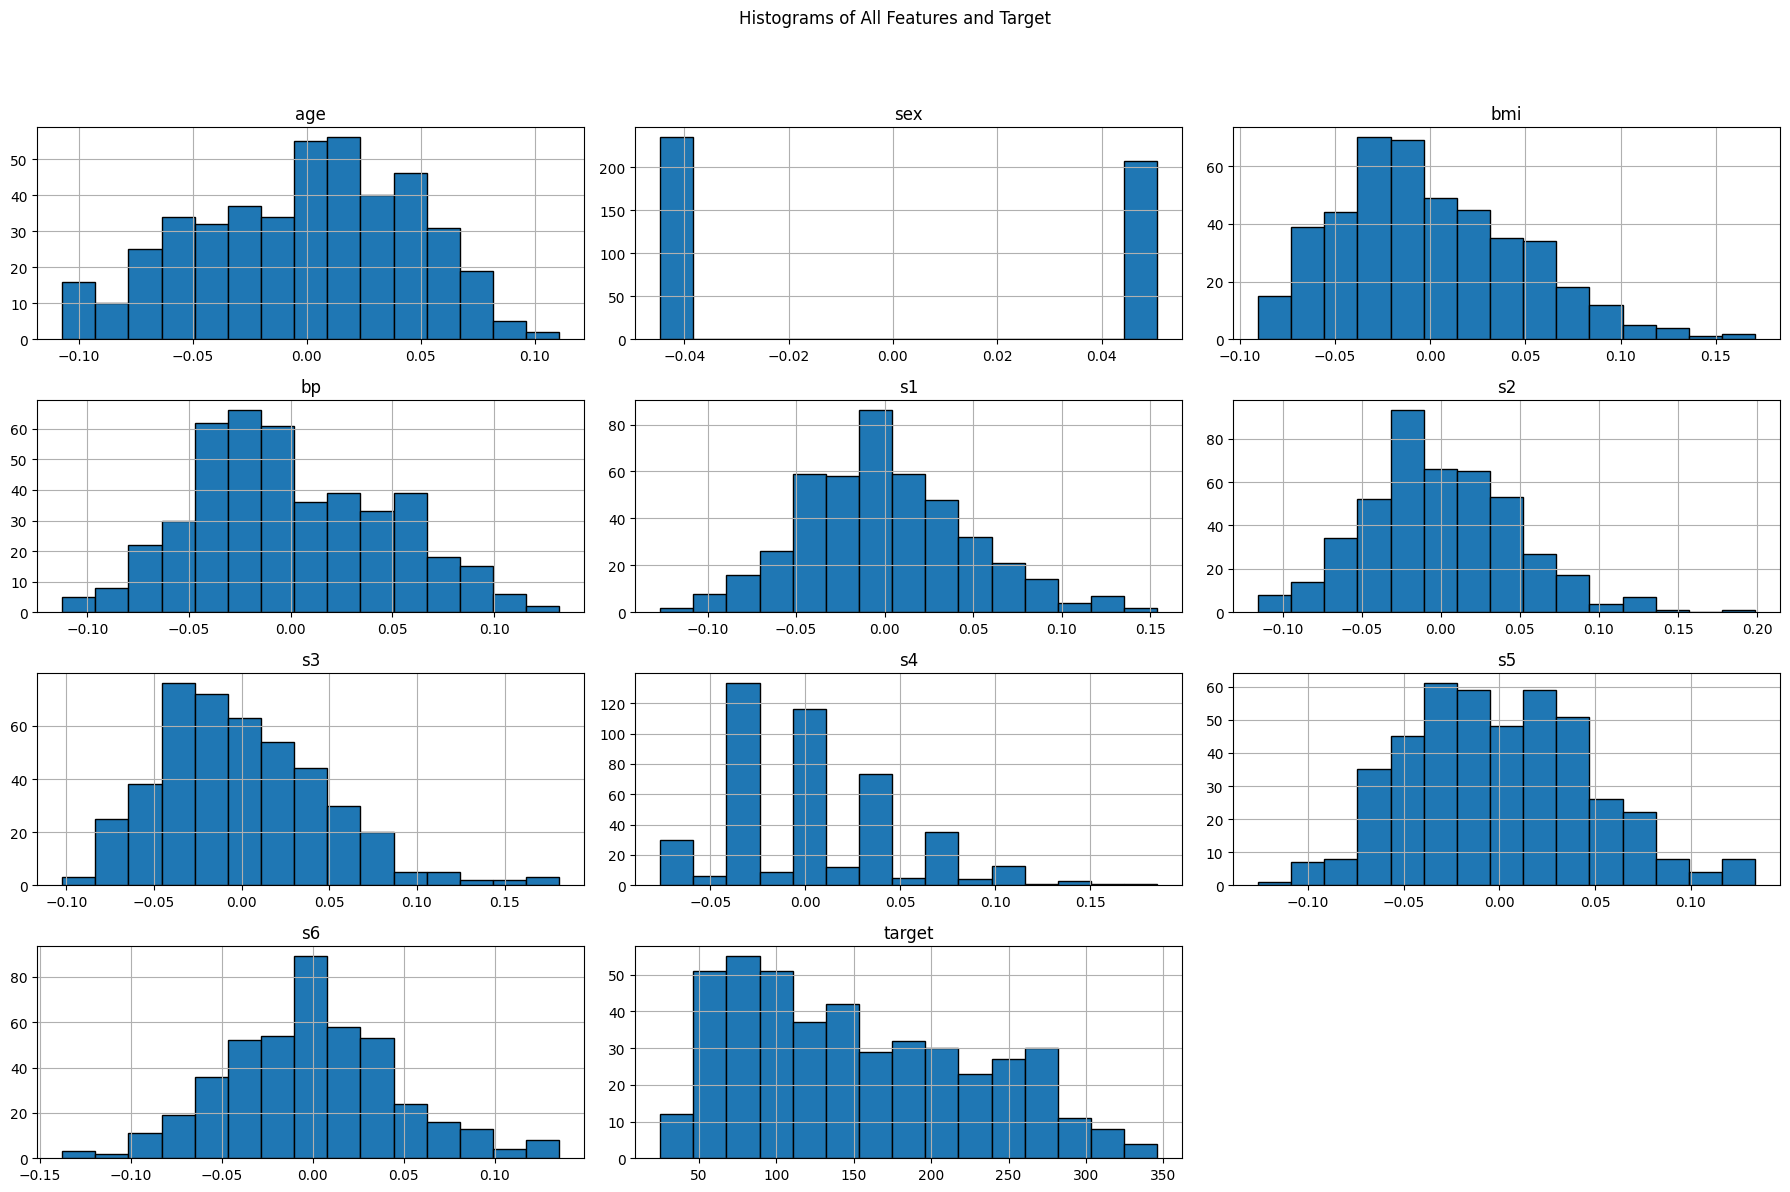

In [7]:
full_df.hist(bins=15, figsize=(18, 12), edgecolor='black')
plt.suptitle("Histograms of All Features and Target", y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

### Scatter Plots (features vs. target) 

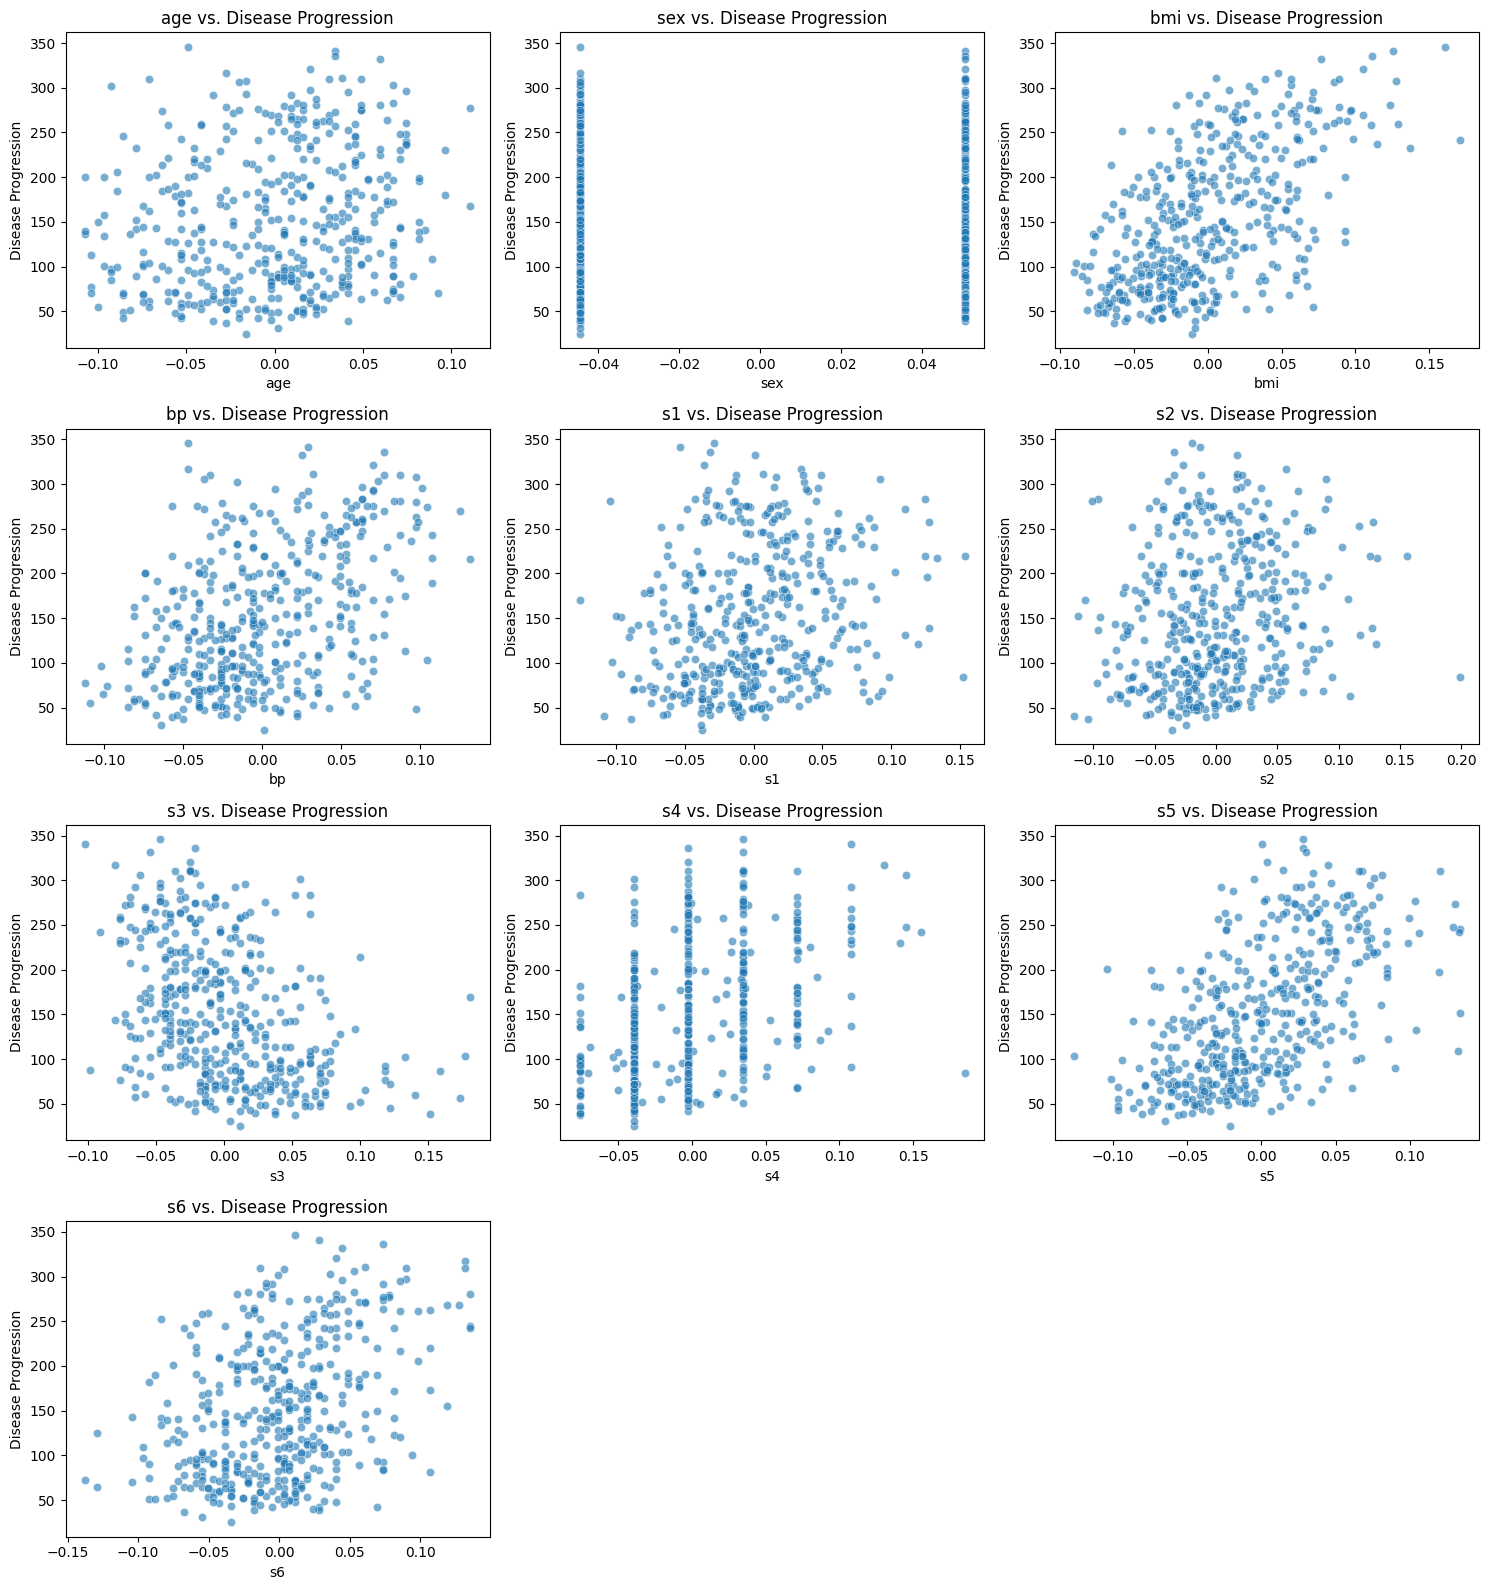

In [8]:
n_features = X.shape[1]
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, col in enumerate(X.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.scatterplot(x=full_df[col], y=full_df['target'], alpha=0.6)
    plt.title(f'{col} vs. Disease Progression')
    plt.xlabel(col)
    plt.ylabel('Disease Progression')
plt.tight_layout()
plt.show()

### Correlation Matrix 

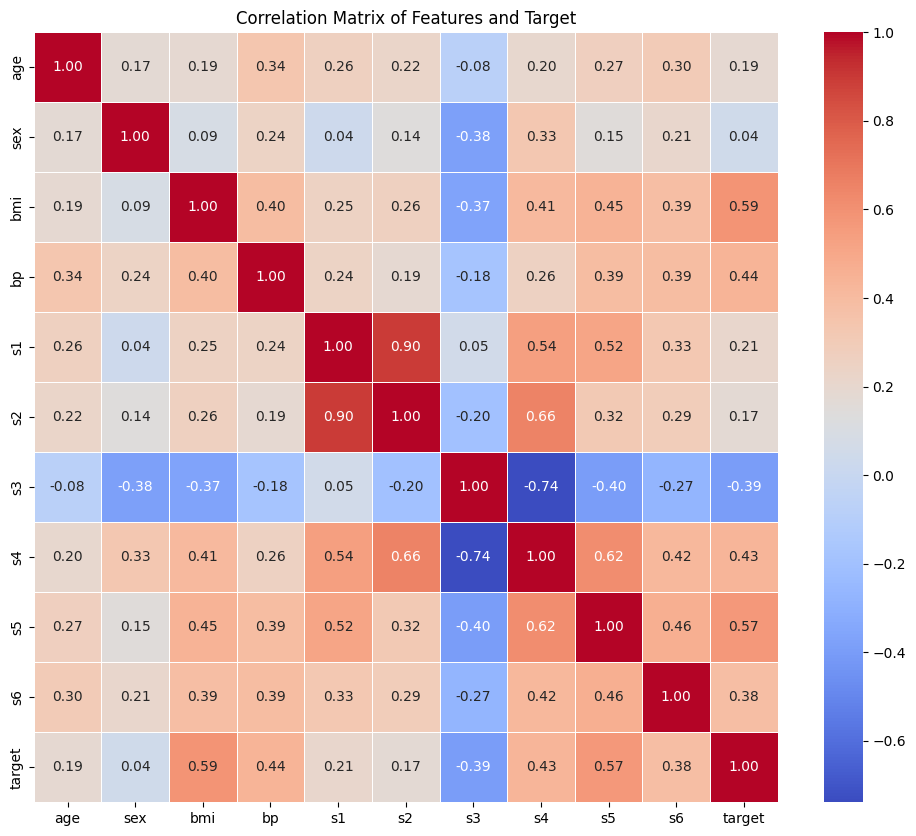

In [9]:
plt.figure(figsize=(12, 10))
sns.heatmap(full_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features and Target')
plt.show()

### Concise and Relevant Insights

* The target variable 'disease progression' seems to have a relatively normal distribution, though slightly skewed to the right.

* Features like 'bmi' and 's5' (possibly a measure of total cholesterol, specifically LDL) show a stronger linear correlation with the target variable compared to others, as indicated by the correlation matrix and scatter plots.

* Other features such as 'bp' (blood pressure) and 's6' (blood sugar level) also show moderate positive correlations.

* Some features, like 'age' and 'gender', show very weak linear correlations with the target, suggesting they might have less individual predictive power in a simple linear model.

* The features are already normalized/scaled, which is typical for Scikit-learn datasets, making them ready for many machine learning algorithms.

* There are no immediately obvious strong non-linear relationships from the scatter plots for most features, though polynomial models might capture subtle curvatures.


## 4. Data Cleaning

Missing values per column

In [10]:
print(full_df.isnull().sum())

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64


Duplicates

In [11]:
print("\nNumber of duplicate rows:", full_df.duplicated().sum())


Number of duplicate rows: 0


# Reasoning for data cleaning

Based on the initial checks, the dataset appears to be very clean:
* There are no missing values in any column, indicating a complete dataset.
* There are no duplicate rows, meaning each observation is unique.

Given this, no explicit data cleaning steps (like imputation or dropping duplicates) are required for this dataset. The data is ready for model building.

### 5. Split the dataset 

Train (75%), validation set (10%), and test set (15%).

Training (75%)

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)

Validation (10%) & Testing (15%)

In [13]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(0.15 / 0.25), random_state=42)

In [14]:
print(f"Original dataset size: {len(X)} samples")
print(f"Train set size: {len(X_train)} samples ({len(X_train)/len(X)*100:.2f}%)")
print(f"Validation set size: {len(X_val)} samples ({len(X_val)/len(X)*100:.2f}%)")
print(f"Test set size: {len(X_test)} samples ({len(X_test)/len(X)*100:.2f}%)")

Original dataset size: 442 samples
Train set size: 331 samples (74.89%)
Validation set size: 44 samples (9.95%)
Test set size: 67 samples (15.16%)


### 6. Univariate Polynomial Regression

### Models: a univariate polynomial regression on the BMI feature versus the "disease progression one year after baseline" - from degree 0 to 5

'BMI' feature for univariate analysis

In [15]:
X_train_bmi = X_train[['bmi']]
X_val_bmi = X_val[['bmi']]
X_test_bmi = X_test[['bmi']]

models_univariate = {}
metrics_results_univariate = []

Function for MAPE to handle potential division by zero

In [16]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true_safe = np.where(y_true == 0, np.finfo(float).eps, y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100
    return mape

In [17]:
for degree in range(6):
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train_bmi)
    X_val_poly = poly_features.transform(X_val_bmi)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    models_univariate[f'Degree {degree}'] = {'model': model, 'poly_transformer': poly_features}

    # Predictions
    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)

    # Calculate metrics
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

    r2_val = r2_score(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    mape_val = mean_absolute_percentage_error(y_val, y_val_pred)

    metrics_results_univariate.append({
        'Model': f'Degree {degree}',
        'R2_Train': r2_train,
        'MAE_Train': mae_train,
        'MAPE_Train': mape_train,
        'R2_Validation': r2_val,
        'MAE_Validation': mae_val,
        'MAPE_Validation': mape_val
    })
    print(f"Trained model for Degree {degree}")

Trained model for Degree 0
Trained model for Degree 1
Trained model for Degree 2
Trained model for Degree 3
Trained model for Degree 4
Trained model for Degree 5


### 7. Model Comparison Table (Train and Validation)

In [18]:
metrics_df_univariate = pd.DataFrame(metrics_results_univariate)

Sort by Validation R-squared for easier comparison

In [19]:
metrics_df_univariate = metrics_df_univariate.sort_values(by='R2_Validation', ascending=False)
print(metrics_df_univariate.round(3).to_string())

      Model  R2_Train  MAE_Train  MAPE_Train  R2_Validation  MAE_Validation  MAPE_Validation
5  Degree 5     0.354     52.059      48.004          0.350          45.462           45.175
4  Degree 4     0.353     52.093      48.053          0.341          46.090           46.050
3  Degree 3     0.351     52.199      48.281          0.332          47.185           47.223
2  Degree 2     0.351     52.207      48.299          0.332          47.214           47.240
1  Degree 1     0.350     52.288      48.363          0.331          47.208           47.060
0  Degree 0     0.000     66.202      62.827         -0.107          66.057           71.264


### 8. Identify Best Univariate Model

In [20]:
best_model_row_univariate = metrics_df_univariate.loc[metrics_df_univariate['R2_Validation'].idxmax()]
best_model_name_univariate = best_model_row_univariate['Model']
best_degree_univariate = int(best_model_name_univariate.split(' ')[1])

print(f"The best univariate model based on validation R-squared is: {best_model_name_univariate}")
print(f"Validation R-squared: {best_model_row_univariate['R2_Validation']:.3f}")
print(f"Validation MAE: {best_model_row_univariate['MAE_Validation']:.3f}")

The best univariate model based on validation R-squared is: Degree 5
Validation R-squared: 0.350
Validation MAE: 45.462


### Evaluate Best Univariate Model on Test Set

In [21]:
best_model_univariate = models_univariate[best_model_name_univariate]['model']
poly_features_best_univariate = models_univariate[best_model_name_univariate]['poly_transformer']

X_test_poly_univariate = poly_features_best_univariate.transform(X_test_bmi)
y_test_pred_univariate = best_model_univariate.predict(X_test_poly_univariate)

if len(y_test_pred_univariate) != len(y_test):
	y_test_aligned = y_test.iloc[:len(y_test_pred_univariate)]
else:
	y_test_aligned = y_test

r2_test_univariate = r2_score(y_test_aligned, y_test_pred_univariate)
mae_test_univariate = mean_absolute_error(y_test_aligned, y_test_pred_univariate)
mape_test_univariate = mean_absolute_percentage_error(y_test_aligned, y_test_pred_univariate)

print(f"\nResults for Best Univariate Model ({best_model_name_univariate}) on Test Set:")
print(f"R-squared (Test): {r2_test_univariate:.3f}")
print(f"MAE (Test): {mae_test_univariate:.3f}")
print(f"MAPE (Test): {mape_test_univariate:.3f}")

print(f"\nResults for Best Univariate Model ({best_model_name_univariate}) on Test Set:")
print(f"R-squared (Test): {r2_test_univariate:.3f}")
print(f"MAE (Test): {mae_test_univariate:.3f}")
print(f"MAPE (Test): {mape_test_univariate:.3f}")


Results for Best Univariate Model (Degree 5) on Test Set:
R-squared (Test): 0.267
MAE (Test): 51.750
MAPE (Test): 43.027

Results for Best Univariate Model (Degree 5) on Test Set:
R-squared (Test): 0.267
MAE (Test): 51.750
MAPE (Test): 43.027


### 10. Plotting Best Univariate Model Fit

d:\College Second Program\CSCN8010-Foundations of Machine Learning Frameworks\PracticalLab2\ProblemLab2_CSCN8010\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


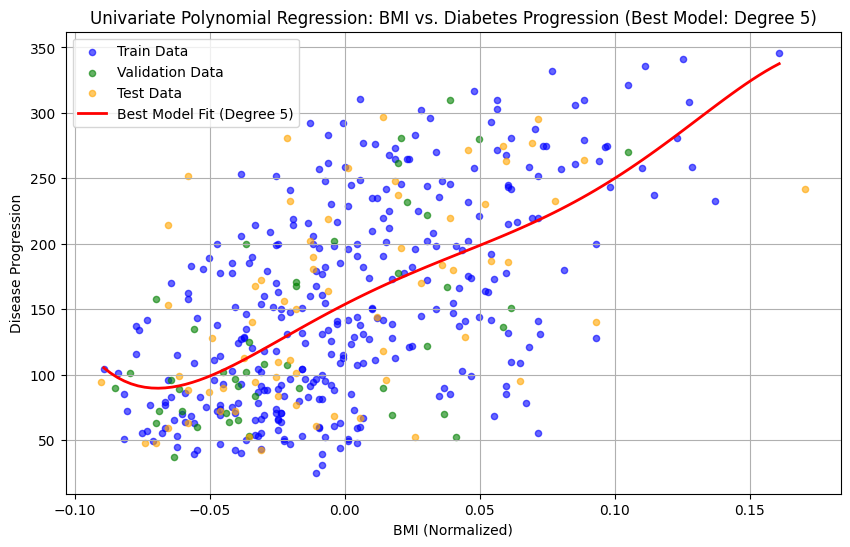

In [22]:
plt.figure(figsize=(10, 6))

bmi_range = np.linspace(X_train_bmi.min(), X_train_bmi.max(), 100).reshape(-1, 1)
bmi_range_poly = poly_features_best_univariate.transform(bmi_range)
y_pred_curve = best_model_univariate.predict(bmi_range_poly)

plt.scatter(X_train_bmi.values.ravel(), y_train.values.ravel(), label='Train Data', alpha=0.6, s=20, color='blue')
plt.scatter(X_val_bmi.values.ravel(), y_val.values.ravel(), label='Validation Data', alpha=0.6, s=20, color='green')
plt.scatter(X_test_bmi.values.ravel(), y_test.values.ravel(), label='Test Data', alpha=0.6, s=20, color='orange')
plt.plot(bmi_range, y_pred_curve, color='red', label=f'Best Model Fit ({best_model_name_univariate})', linewidth=2)

plt.title(f'Univariate Polynomial Regression: BMI vs. Diabetes Progression (Best Model: {best_model_name_univariate})')
plt.xlabel('BMI (Normalized)')
plt.ylabel('Disease Progression')
plt.legend()
plt.grid(True)
plt.show()

### Equation of the Bet Univariate Model

In [23]:
coefficients = best_model_univariate.coef_
intercept = best_model_univariate.intercept_

equation_terms = [f"{intercept:.2f}"]

if best_degree_univariate == 0:
    equation = f"y = {intercept:.2f}"
else:
    for i, coef in enumerate(coefficients):
        if i == 0 and best_degree_univariate > 0:
            equation_terms.append(f"{coef:.2f} * BMI")
        elif i > 0:
            equation_terms.append(f"{coef:.2f} * BMI^{i+1}")

    equation = "y = " + " + ".join(equation_terms)
    equation = equation.replace("+ -", "- ")

print(f"Equation of the Best Univariate Model ({best_model_name_univariate}):")
print(equation)

Equation of the Best Univariate Model (Degree 5):
y = 153.65 + 0.00 * BMI + 1059.89 * BMI^2 - 3824.15 * BMI^3 - 16770.23 * BMI^4 + 753722.52 * BMI^5 - 2993716.57 * BMI^6


### 12. Predict for a Chosen BMI Value

In [24]:
chosen_bmi_value = np.array([[0.05]])

chosen_bmi_poly = poly_features_best_univariate.transform(chosen_bmi_value)

predicted_progression = best_model_univariate.predict(chosen_bmi_poly)
print(f"Expected diabetes progression for a normalized BMI of {chosen_bmi_value[0][0]:.2f}: {predicted_progression[0]:.2f}")

Expected diabetes progression for a normalized BMI of 0.05: 198.77


d:\College Second Program\CSCN8010-Foundations of Machine Learning Frameworks\PracticalLab2\ProblemLab2_CSCN8010\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


### Number of Trainable Parameters

For the Best Univariate Model (Degree 5):
The number of trainable parameters is: 7

Explanation:
For a univariate polynomial regression model of degree 5:
* The `PolynomialFeatures` transformer creates 5 polynomial terms (BMI, BMI^2, ..., BMI^5) from the single 'bmi' feature.
* The `LinearRegression` model then fits a coefficient for each of these {best_degree_univariate} terms.
* Additionally, there is one intercept term (also known as the bias term).
* So, the total number of trainable parameters is 5 (coefficients for terms) + 1 (intercept) = 7.

Polynomial features generated by PolynomialFeatures (Degree 5): ['1' 'bmi' 'bmi^2' 'bmi^3' 'bmi^4' 'bmi^5']

### Conclusion for Univariate Model

Summary of Univariate Model Performance:
The selected univariate polynomial regression model of Degree 5 was evaluated on the test set, yielding the following results:
* R-squared (Test): 0.267
* MAE (Test): 51.750
* MAPE (Test): 43.027%
The R-squared value indicates the proportion of variance in diabetes progression explained by BMI in this model.
The MAE and MAPE quantify the average magnitude of prediction errors.

Where the Univariate Model Fails and its Limitations:
Despite identifying a 'best' univariate model, its utility is inherently limited:
1.  **Limited Predictive Power:** Diabetes progression is a complex condition influenced by numerous physiological factors beyond just BMI. A model relying solely on BMI is likely to be oversimplified and thus capture only a fraction of the true variability in the target variable. This is reflected in the moderate R-squared value.
2.  **Risk of Underfitting:** By considering only one feature, the model might be underfitting the true underlying relationship, meaning it's too simple to capture the complexity of diabetes progression, which involves interactions between multiple features.
3.  **Generalizability:** While it performed adequately on the test set (which is a small portion of the overall data), its generalizability to a wider, more diverse patient population might be questionable due to its simplistic nature.
4.  **Clinical Utility:** For physicians, a single-factor prediction tool might not provide sufficient comprehensive insight for patient screening. Real-world medical decisions typically leverage a broader range of patient data.
In summary, while this univariate model serves as a good academic exercise for understanding polynomial regression, it highlights the necessity of incorporating more features for a more robust and clinically relevant predictive model.

# Multivariate Models

In [25]:
X_train_multi = X_train
X_val_multi = X_val
X_test_multi = X_test

multi_model_metrics_results = []
models_multivariate = {}

def record_metrics(model_name, y_train_true, y_train_pred, y_val_true, y_val_pred, model_object, transformer_object=None):
    r2_train = r2_score(y_train_true, y_train_pred)
    mae_train = mean_absolute_error(y_train_true, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train_true, y_train_pred)

    r2_val = r2_score(y_val_true, y_val_pred)
    mae_val = mean_absolute_error(y_val_true, y_val_pred)
    mape_val = mean_absolute_percentage_error(y_val_true, y_val_pred)

    multi_model_metrics_results.append({
        'Model': model_name,
        'R2_Train': r2_train,
        'MAE_Train': mae_train,
        'MAPE_Train': mape_train,
        'R2_Validation': r2_val,
        'MAE_Validation': mae_val,
        'MAPE_Validation': mape_val
    })
    models_multivariate[model_name] = {'model': model_object, 'transformer': transformer_object}

### Two Multivariate Polynomial Models

In [26]:
polynomial_degrees_multi = [2, 3]

for degree in polynomial_degrees_multi:
    poly_transformer = PolynomialFeatures(degree=degree, include_bias=False)
    model = LinearRegression()

    X_train_poly = poly_transformer.fit_transform(X_train_multi)
    model.fit(X_train_poly, y_train)

    y_train_pred = model.predict(X_train_poly)
    X_val_poly = poly_transformer.transform(X_val_multi)
    y_val_pred = model.predict(X_val_poly)

    record_metrics(f'Multivariate Polynomial (Degree {degree})',
                   y_train, y_train_pred, y_val, y_val_pred,
                   model, poly_transformer)
    print(f"Trained Multivariate Polynomial (Degree {degree})")

Trained Multivariate Polynomial (Degree 2)
Trained Multivariate Polynomial (Degree 3)


### Two Decision Trees

Training Decision Tree Models

In [27]:
max_depths = [3, 7]

for depth in max_depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train_multi, y_train)

    y_train_pred = model.predict(X_train_multi)
    y_val_pred = model.predict(X_val_multi)

    record_metrics(f'Decision Tree (Max Depth {depth})',
                   y_train, y_train_pred, y_val, y_val_pred,
                   model)
    print(f"Trained Decision Tree (Max Depth {depth})")

Trained Decision Tree (Max Depth 3)
Trained Decision Tree (Max Depth 7)


### Two kNNs

Training kNN Models

In [28]:
n_neighbors_values = [5, 10]

for n_neighbors in n_neighbors_values:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsRegressor(n_neighbors=n_neighbors))
    ])

    pipeline.fit(X_train_multi, y_train)

    y_train_pred = pipeline.predict(X_train_multi)
    y_val_pred = pipeline.predict(X_val_multi)

    record_metrics(f'kNN (Neighbors {n_neighbors})',
                   y_train, y_train_pred, y_val, y_val_pred,
                   pipeline)
    print(f"Trained kNN (Neighbors {n_neighbors})")


Trained kNN (Neighbors 5)
Trained kNN (Neighbors 10)


### Compare Multivariate Models

In [29]:
metrics_df_multi = pd.DataFrame(multi_model_metrics_results)
metrics_df_multi = metrics_df_multi.sort_values(by='R2_Validation', ascending=False)
print(metrics_df_multi.round(3).to_string())

                                Model  R2_Train  MAE_Train  MAPE_Train  R2_Validation  MAE_Validation  MAPE_Validation
0  Multivariate Polynomial (Degree 2)     0.605     39.216      34.606          0.426          41.802           42.277
5                  kNN (Neighbors 10)     0.507     43.930      37.988          0.390          42.341           40.168
4                   kNN (Neighbors 5)     0.568     40.839      35.060          0.326          44.245           41.800
2         Decision Tree (Max Depth 3)     0.510     44.260      38.867          0.198          48.126           47.673
3         Decision Tree (Max Depth 7)     0.835     21.594      19.702         -0.271          61.482           57.145
1  Multivariate Polynomial (Degree 3)     0.910     15.651      14.357        -43.280         241.215          231.212


### Identify the best multivariate model based on validation metrics

In [30]:
best_multi_model_row = metrics_df_multi.loc[metrics_df_multi['R2_Validation'].idxmax()]
best_multi_model_name = best_multi_model_row['Model']
print(f"\nThe best multivariate model based on validation R-squared is: {best_multi_model_name}")


The best multivariate model based on validation R-squared is: Multivariate Polynomial (Degree 2)


## Overall Best Model Selection and Test Evaluation

In [31]:
all_metrics_df = pd.concat([metrics_df_univariate, metrics_df_multi], ignore_index=True)
all_metrics_df_sorted = all_metrics_df.sort_values(by='R2_Validation', ascending=False)

overall_best_model_row = all_metrics_df_sorted.iloc[0]
overall_best_model_name = overall_best_model_row['Model']

print(f"Overall best model based on validation R-squared: {overall_best_model_name}")

X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

final_model_for_test = None
final_poly_transformer = None
final_scaler = None

if "Univariate Polynomial" in overall_best_model_name:
    degree = int(overall_best_model_name.split(' ')[1])
    final_poly_transformer = PolynomialFeatures(degree=degree)
    X_train_val_poly = final_poly_transformer.fit_transform(X_train_val[['bmi']])
    final_model_for_test = LinearRegression()
    final_model_for_test.fit(X_train_val_poly, y_train_val)
    X_test_final_transformed = final_poly_transformer.transform(X_test[['bmi']])

elif "Multivariate Polynomial" in overall_best_model_name:
    degree = int(overall_best_model_name.split(' ')[-1].replace(')', ''))
    final_poly_transformer = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_val_poly = final_poly_transformer.fit_transform(X_train_val)
    final_model_for_test = LinearRegression()
    final_model_for_test.fit(X_train_val_poly, y_train_val)
    X_test_final_transformed = final_poly_transformer.transform(X_test)

elif "Decision Tree" in overall_best_model_name:
    max_depth = int(overall_best_model_name.split(' ')[-1].replace(')', ''))
    final_model_for_test = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    final_model_for_test.fit(X_train_val, y_train_val)
    X_test_final_transformed = X_test # No special transformation beyond original features

elif "kNN" in overall_best_model_name:
    n_neighbors = int(overall_best_model_name.split(' ')[-1].replace(')', ''))
    final_scaler = StandardScaler()
    X_train_val_scaled = final_scaler.fit_transform(X_train_val)
    final_model_for_test = KNeighborsRegressor(n_neighbors=n_neighbors)
    final_model_for_test.fit(X_train_val_scaled, y_train_val)
    X_test_final_transformed = final_scaler.transform(X_test) # Scale test set using fitted scaler

else:
    print("Error: Could not identify the overall best model for final retraining.")
    final_model_for_test = None # Set to None to prevent errors later

if final_model_for_test:
    y_test_pred_overall_best = final_model_for_test.predict(X_test_final_transformed)

    r2_test_overall_best = r2_score(y_test, y_test_pred_overall_best)
    mae_test_overall_best = mean_absolute_error(y_test, y_test_pred_overall_best)
    mape_test_overall_best = mean_absolute_percentage_error(y_test, y_test_pred_overall_best)

    print(f"\nFinal Results for Overall Best Model ({overall_best_model_name}) on Test Set")
    print(f"R-squared (Test): {r2_test_overall_best:.3f}")
    print(f"MAE (Test): {mae_test_overall_best:.3f}")
    print(f"MAPE (Test): {mape_test_overall_best:.3f}%")
else:
    print("Cannot provide final test results as the overall best model was not identified or trained properly.")

Overall best model based on validation R-squared: Multivariate Polynomial (Degree 2)

Final Results for Overall Best Model (Multivariate Polynomial (Degree 2)) on Test Set
R-squared (Test): 0.380
MAE (Test): 45.561
MAPE (Test): 37.835%


# Conclusion


Final Overall Conclusion
Summary of Overall Model Performance:
After evaluating various univariate and multivariate models, the **Multivariate Polynomial (Degree 2)** emerged as the top-performing model based on its performance on the validation set. Its final performance on the unseen test set is:
- R-squared: 0.380
- MAE: 45.561
- MAPE: 37.835%

Comparison and Insights:
- The multivariate models, particularly the Multivariate Polynomial Regression models, generally showed significantly better R-squared values on the validation set compared to the univariate BMI model. This indicates that incorporating all available features substantially improves the model's ability to explain the variance in diabetes progression.
- Decision Trees and kNNs also offered competitive performance, highlighting the utility of non-parametric models for this dataset. Decision Trees provide interpretable rules, while kNN is effective for capturing local data structures.
- The performance metrics (R-squared, MAE, MAPE) provide a comprehensive view. A higher R-squared suggests a better fit, while lower MAE and MAPE indicate more accurate predictions in absolute and percentage terms, respectively.

Where the Models Still Fail and General Limitations:
Despite the improvements from multivariate modeling, certain limitations persist:
1.  **Dataset Size and Scope:** The diabetes dataset is a 'toy' dataset with a relatively small number of samples (442). While useful for learning, real-world clinical applications typically require much larger and more diverse datasets for robust model training and validation.
2.  **Model Complexity vs. Interpretability:** More complex models, like high-degree polynomial regression with many features or deep decision trees, can become 'black boxes,' making it challenging for physicians to understand why a particular prediction was made. This can hinder trust and adoption in clinical settings.
3.  **Assumptions:** Each model type has underlying assumptions (e.g., linear relationships for linear regression, feature independence for some models, local similarity for kNN). If these assumptions are violated, model performance may suffer.
4.  **Bias and Fairness:** In real clinical applications, it's crucial to assess models for potential biases (e.g., performance differences across demographic groups) to ensure equitable outcomes. This analysis was beyond the scope of this lab but is a critical consideration.
5.  **Causality vs. Correlation:** These models identify correlations between features and diabetes progression but do not establish causality. Medical professionals need to understand causative factors for effective intervention.

Future Work:
To further improve the predictive capabilities and clinical utility, future work could involve:
- **Feature Engineering:** Creating new features from existing ones (e.g., ratios, interactions between specific features) that might better capture underlying medical relationships.
- **Advanced Models:** Exploring more sophisticated machine learning algorithms like Random Forests, Gradient Boosting Machines (e.g., XGBoost, LightGBM), or Neural Networks, which often handle complex, non-linear relationships and interactions more effectively.
- **Hyperparameter Tuning:** Performing more exhaustive hyperparameter tuning using techniques like GridSearchCV or RandomizedSearchCV with cross-validation to find optimal model configurations.
- **External Validation:** Testing the final model on independent, external datasets to rigorously assess its generalizability to new patient populations.
Overall, this lab provided a strong foundation in applying various regression models and evaluation techniques. The transition from univariate to multivariate approaches clearly demonstrated the benefits of comprehensive feature utilization in predicting complex health outcomes.

# Univariate Polynomial Regression on BMI

In [32]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

X_bmi = full_df[['bmi']]
y = full_df['target']

X_temp, X_test, y_temp, y_test = train_test_split(X_bmi, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

results = []

for degree in range(6):
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)

    results.append({
        'Degree': degree,
        'Train R2': r2_score(y_train, y_train_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
        'Val R2': r2_score(y_val, y_val_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Val MAPE': mean_absolute_percentage_error(y_val, y_val_pred),
    })

results_df = pd.DataFrame(results)
results_df


,Degree,Train R2,Train MAE,Train MAPE,Val R2,Val MAE,Val MAPE
0,0,0.000000,66.677284,0.639227,-0.044256,64.128788,0.525470
1,1,0.354533,51.545876,0.490114,0.373934,50.347524,0.380543
2,2,0.358797,51.395780,0.488103,0.356718,50.451838,0.382935
3,3,0.359433,51.299109,0.486731,0.353727,50.362661,0.381894
4,4,0.359730,51.254415,0.486313,0.359600,50.213482,0.380189
5,5,0.359835,51.319651,0.486620,0.362287,49.990345,0.378466


### Select Best Model

In [33]:

best_model_row = results_df.loc[results_df['Val R2'].idxmax()]
best_degree = int(best_model_row['Degree'])
best_degree


1

### Evaluate Best Model on Test Set

In [34]:

X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

poly_best = PolynomialFeatures(best_degree)
X_trainval_poly = poly_best.fit_transform(X_trainval)
X_test_poly = poly_best.transform(X_test)

best_model = LinearRegression()
best_model.fit(X_trainval_poly, y_trainval)

y_test_pred = best_model.predict(X_test_poly)

test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

test_r2, test_mae, test_mape


(0.23335039815872138, 52.25997644534553, 0.4587747779877976)

### Plot Fit of the Chosen Model

d:\College Second Program\CSCN8010-Foundations of Machine Learning Frameworks\PracticalLab2\ProblemLab2_CSCN8010\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


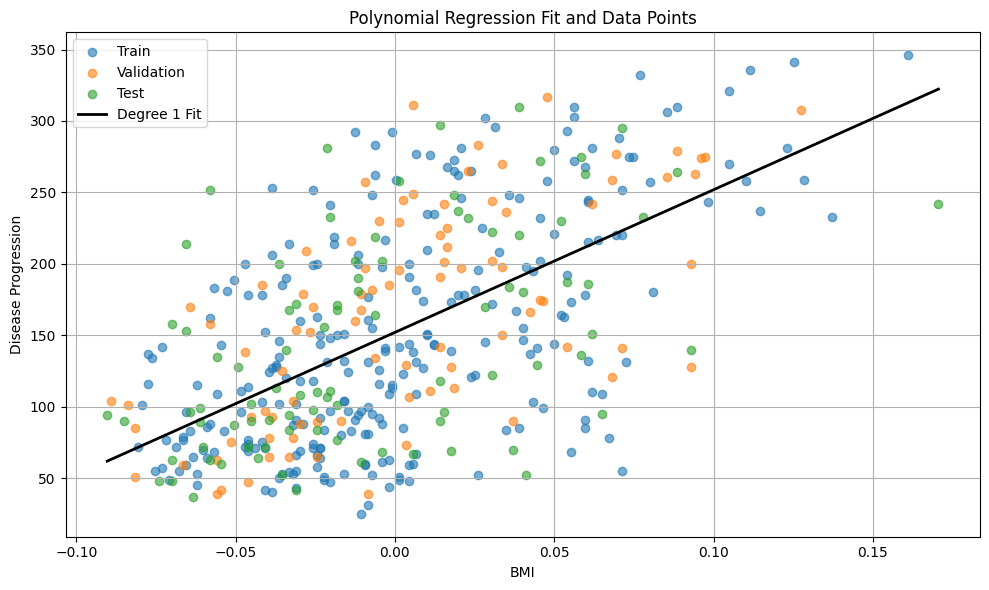

In [35]:
bmi_range = np.linspace(X_bmi.min(), X_bmi.max(), 300).reshape(-1, 1)
bmi_range_poly = poly_best.transform(bmi_range)
y_range_pred = best_model.predict(bmi_range_poly)

plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, label='Train', alpha=0.6)
plt.scatter(X_val, y_val, label='Validation', alpha=0.6)
plt.scatter(X_test, y_test, label='Test', alpha=0.6)
plt.plot(bmi_range, y_range_pred, color='black', label=f'Degree {best_degree} Fit', linewidth=2)
plt.xlabel('BMI')
plt.ylabel('Disease Progression')
plt.title('Polynomial Regression Fit and Data Points')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Equation of the Best Model

In [36]:

coefs = best_model.coef_
intercept = best_model.intercept_

equation_terms = [f"{intercept:.2f}"]
for i, coef in enumerate(coefs[1:], start=1):
    equation_terms.append(f"{coef:.2f}*x^{i}")

equation_str = " + ".join(equation_terms)
equation_str


'152.00 + 998.58*x^1'

### Prediction Example

In [37]:

sample_bmi = np.array([[0.05]])
sample_bmi_poly = poly_best.transform(sample_bmi)
best_model.predict(sample_bmi_poly)[0]


d:\College Second Program\CSCN8010-Foundations of Machine Learning Frameworks\PracticalLab2\ProblemLab2_CSCN8010\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


np.float64(201.9322386713597)

### Trainable Parameters

In [38]:

feature_names_out = poly_best.get_feature_names_out(['bmi'])
len(feature_names_out), feature_names_out


(2, array(['1', 'bmi'], dtype=object))


### Conclusion

The polynomial regression analysis using BMI as a predictor shows that a **degree 1** model (linear regression) performs best overall on the validation set. Despite experimenting with higher-degree polynomials, no significant improvement was observed—suggesting the relationship between BMI and disease progression is roughly linear in this dataset.

**Model Strengths**:
- Simple and interpretable.
- Avoids overfitting, which can occur with higher-degree models.

**Model Weaknesses**:
- Limited predictive power (**R² ~ 0.23** on the test set).
- Only one feature (BMI) is used, ignoring other relevant clinical features (e.g., blood pressure, glucose levels).
- Moderate error rates (e.g., MAPE ≈ 46%) suggest limited clinical usability on its own.

**Future Improvements**:
- Incorporate multiple features for multivariate modeling.
- Try non-linear models (e.g., decision trees or ensemble methods).
- Explore interaction terms and feature engineering to capture richer patterns.


# Multivariate Modeling with All Features


In this part, we repeat the modeling process using all features in the dataset (not just BMI).
We evaluate six models:
- Two polynomial regression models (degrees 2 and 3)
- Two decision tree regressors (max_depth 3 and 5)
- Two kNN regressors (k = 3 and 5)
    

In [39]:

from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

X_all = full_df.drop(columns='target')
y_all = full_df['target']

X_temp, X_test, y_temp, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

results_part3 = []

for degree in [2, 3]:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    results_part3.append({
        'Model': f'Poly Deg {degree}',
        'Train R2': r2_score(y_train, y_train_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
        'Val R2': r2_score(y_val, y_val_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Val MAPE': mean_absolute_percentage_error(y_val, y_val_pred),
    })

for depth in [3, 5]:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    results_part3.append({
        'Model': f'Decision Tree (depth={depth})',
        'Train R2': r2_score(y_train, y_train_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
        'Val R2': r2_score(y_val, y_val_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Val MAPE': mean_absolute_percentage_error(y_val, y_val_pred),
    })

for k in [3, 5]:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    results_part3.append({
        'Model': f'kNN (k={k})',
        'Train R2': r2_score(y_train, y_train_pred),
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Train MAPE': mean_absolute_percentage_error(y_train, y_train_pred),
        'Val R2': r2_score(y_val, y_val_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Val MAPE': mean_absolute_percentage_error(y_val, y_val_pred),
    })

results_part3_df = pd.DataFrame(results_part3)
results_part3_df.sort_values(by='Val R2', ascending=False)
    

,Model,Train R2,Train MAE,Train MAPE,Val R2,Val MAE,Val MAPE
5,kNN (k=5),0.562926,4.075606e+01,3.672729e-01,0.396570,45.943820,0.324438
2,Decision Tree (depth=3),0.538219,4.310559e+01,3.910118e-01,0.381189,46.569194,0.360157
0,Poly Deg 2,0.627777,3.819712e+01,3.445925e-01,0.360201,46.646216,0.325821
3,Decision Tree (depth=5),0.672237,3.503869e+01,3.271126e-01,0.355059,47.079763,0.343530
4,kNN (k=3),0.638104,3.684470e+01,3.312816e-01,0.306332,46.243446,0.333245
1,Poly Deg 3,1.000000,3.902783e-10,3.535549e-12,-858.855212,1055.506159,7.896502


### Conclusion


From the six multivariate models tested, the best-performing model based on validation R² is:

- **kNN with k=5**
    - **Validation R²**: 0.397
    - **MAE**: 45.94
    - **MAPE**: 32.4%

#### Key Insights:
- **Polynomial Regression (deg=3)** suffers from severe overfitting.
- **Decision Trees** improve with depth but begin to overfit beyond depth=3.
- **kNN (k=5)** strikes a balance between fitting and generalization.

#### Recommendation:
kNN with `k=5` is currently the most balanced and effective among the evaluated models, though further improvement could be explored with feature scaling, model ensembles, or cross-validation.
